# Analyzing the Social Networks of over 1.6 Billion Reddit Comments

This notebook gives detailed information to help better understand our [paper](http://homes.cs.washington.edu/~fire/pdf/reddatait.pdf) and our [web interface](http://homes.cs.washington.edu/~fire/reddatait/). In this notebook, we will demonstrate how to construct the subreddits' social networks created by more than 1.6 billion comments. Additionally, we will demonstrate how to calculate various statistics related to the subreddits.
This code is licensed under a BSD license. See [license file](http://homes.cs.washington.edu/~fire/LICENSE).


## 0. Setup 

Before we begin, make sure you have installed all the required Python packages. (The instructions below use pip. You can use easy_install, too.) Also, consider using virtualenv for a cleaner installation experience instead of sudo. I also recommend running the code via IPython Notebook.

* sudo pip install --upgrade graphlab-create # We mainly used [SFrame object](https://github.com/turi-code/SFrame), which is an open source package.
* sudo pip install --upgrade praw
* sudo pip install --upgrade seaborn
* sudo pip install --upgrade networkx


## 1. Preparing the Dataset

First, we need to download the 250GB Reddit dataset file from this torrent link. This dataset was created by [Jason Michael Baumgartner](https://twitter.com/jasonbaumgartne). Additional details about how this dataset was constructed can be found at this link. Downloading this 250GB dataset can take a considerable amount of time. To save time, you can download only one month’s, or several months’, worth of data.

After we download the dataset, we notice that the dataset is organized in directories, where each directory contains the posts of a specific year. These directories contain posts that were published between October 2007 and May 2015. Let's create a single SFrame that contains all these posts. To achieve this, we first will convert each monthly zipped file into an SFrame object using the following code:


In [1]:
import os
import logging
import bz2
from datetime import datetime
import graphlab as gl
import graphlab.aggregate as agg
import fnmatch

gl.canvas.set_target('ipynb')
gl.set_runtime_config('GRAPHLAB_CACHE_FILE_LOCATIONS', '/mnt/tmp')


base_dir = "/mnt/data/reddit" # Replace this with the directory which you downloaded the file into
sframes_dir = base_dir + "/sframes/" # Replace this with the directory you want to save the SFrame to
tmp_dir =  "/mnt/tmp" # Replace this with the directory you want to save the SFrame to

def get_month_from_path(path):
    m = os.path.basename(path)
    m = m.split(".")[0]
    return int(m.split("-")[-1])

def get_year_from_path(path):
    y = os.path.basename(path)
    y = y.split(".")[0]
    return int(y.lower().replace("rc_","").split("-")[0])

def json2sframe(path):
    """
    Creates an SFrame object from the file in the input path
    :param path: path to a file that contains a list of JSON objects, each JSON is saved in a separate line.
        The file can also be compressed in bz2 format.
    :return: SFrame object created from the file in the input path. The SFrame also contains information regarding
     each post date & time
    :rtype: gl.SFrame
    """
    if not path.endswith(".bz2"):
        sf = gl.SFrame.read_json(path, orient="lines")
    else:
        dpath = decompress_bz2(path)
        sf = gl.SFrame.read_json(dpath, orient="lines")
        #remove the decompressed file
        os.remove(dpath)
    #add datetime information
    sf['month'] = get_month_from_path(path)
    sf['year'] = get_year_from_path(path)
    sf['datetime']= sf["created_utc"].apply(lambda utc: datetime.fromtimestamp(float(utc)))

    return sf

def decompress_bz2(inpath, outpath=None):
    """
    Decompress bz2 to the outpath, if the outpath is not provided then decompress the file to the inpath directory
    :param inpath: decompress bz2 file to the outpath
    :param outpath: output path for the decompress file
    :return: the output file path
    """
    if outpath is None:
        outpath = tmp_dir + os.path.sep + os.path.basename(inpath) + ".decompressed"
    out_file = file(outpath, 'wb')
    logging.info("Decompressing file %s to %s" % (inpath,outpath))
    in_file = bz2.BZ2File(inpath, 'rb')
    for data in iter(lambda : in_file.read(100 * 1024), b''):
        out_file.write(data)
    out_file.close()
    in_file.close()
    return outpath

def match_files_in_dir(basedir, ext):
    """
    Find all files in the basedir with 'ext' as filename extension
    :param basedir: input basedir
    :param ext: filename extension
    :return: list of file paths with the input extension
    """
    matches = []
    for root, dirnames, filenames in os.walk(basedir):
        for filename in fnmatch.filter(filenames, ext):
            matches.append(os.path.join(root, filename))
    return matches

#Creating all SFrames
for p in match_files_in_dir(basedir, "*.bz2"):
    logging.info("Analyzing of %s " % p)
    outp = sframes_dir + os.path.sep + os.path.basename(p).replace(".bz2", ".sframe")
    if os.path.isdir(outp):
        logging.info("Skipping the analysis of %s file" % p)
        continue
    sf = json2sframe(p)
    sf.save(outp)

[INFO] GraphLab Create v1.8.3 started. Logging: /tmp/graphlab_server_1234.log


Read 87760 lines. Lines per second: 64370.3

Finished parsing file ./notebook/tmp/RC_2007-10.bz2.decompressed

Parsing completed. Parsed 150429 lines in 1.85381 secs.

------------------------------------------------------
Inferred types from first line of file as 
column_type_hints=[dict]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------
./notebook/RC_2007-10.sframe

Finished parsing file ./notebook/RC_2007-11.bz2.decompressed

Parsing completed. Parsed 100 lines in 0.65502 secs.


------------------------------------------------------

Read 100440 lines. Lines per second: 72496.1

Finished parsing file ./notebook/RC_2007-11.bz2.decompressed

Parsing completed. Parsed 372983 lines in 3.7184 secs.


Inferred types from first line of file as 
column_type_hints=[dict]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------
./notebook/RC_2007-11.sframe
...

Now let’s join all the SFrame objects into a single object. Please notice that different posts contain different metadata information about each post. Therefore, we will create a single SFrame which contains all the various metadata information.


In [2]:
join_sframe_path = sframes_dir + os.path.sep + "join_all.sframe" # Where to save the join large SFrame object
def get_all_cols_names(sframes_dir):
    """
    Return the column names of all SFrames in the input path
    :param sframes_dir: directory path which contains SFrames
    :return: list of all the column names in all the sframes in the input directory
    :rtype: set()
    """
    sframes_paths = [sframes_dir + os.path.sep + s for s in  os.listdir(sframes_dir)]
    column_names = set()
    for p in sframes_paths:
        if not p.endswith(".sframe"):
            continue
        print p
        sf = gl.load_sframe(p)
        column_names |= set(sf.column_names())
    return column_names

def get_sframe_columns_type_dict(sf):
    """
    Returns a dict with the sframe column names as keys and column types as values
    :param sf: input SFrame
    :return: dict with the sframe column names as keys and column types as values
    :rtype dict[str,str]
    """
    n = sf.column_names()
    t = sf.column_types()

    return {n[i]: t[i]for i in range(len(n))}

def update_sframe_columns_types(sf, col_types):
    """
    Updates the input sframe column types according to the input types dict.
    :param sf: input SFrame object
    :param col_types: dict in which the keys are the column names and the values are the columns types
    :return: SFrame object with column types update to the col_types dict. If a column doesn't exist in the SFrame object
     then a new column is added with None values
    :rtype: gl.SFrame
    """
    sf_cols_dict = get_sframe_columns_type_dict(sf)

    for k,v in col_types.iteritems():
        if k not in sf_cols_dict:
            sf[k] = None
            sf[k] = sf[k].astype(v)
        elif v != sf_cols_dict[k]:
            sf[k] = sf[k].astype(v)
    return sf

def join_all_sframes(sframes_dir, col_types):
    """
    Joins all SFrames in the input directory where the column types are according to col_types dict
    :param sframes_dir:
    :param col_types: dict with column names and their corresponding types
    :return: merged SFrame of all the SFrames in the input directory
    "rtype: gl.SFrame
    """
    sframes_paths = [sframes_dir + os.path.sep + s for s in  os.listdir(sframes_dir) if s.endswith(".sframe")]
    sframes_paths.sort()
    sf = gl.load_sframe(sframes_paths[0])
    sf = update_sframe_columns_types(sf, col_types)
    for p in sframes_paths[1:]:
        if not p.endswith(".sframe"):
            continue
        print "Joining %s" % p
        sf2 = update_sframe_columns_types(gl.load_sframe(p), col_types)
        sf2.__materialize__()
        sf = sf.append(sf2)
        sf.__materialize__()

    return sf



# use the inferred column type according to last month posts' SFrame. Set all other columns to be 
# as type str
col_names = get_all_cols_names(sframes_dir)
sf = gl.load_sframe(sframes_dir + '/RC_2015-05.sframe')
d = get_sframe_columns_type_dict(sf)
for c in col_names:
    if c not in d:
        print "Found new column %s" %c
    d[c] = str

#Create Single SFrame
sf = join_all_sframes(sframes_dir, d)
sf.save(join_sframe_path)

At the end of this process, we obtained an SFrame with 1,659,361,605 rows, which is about 289 GB in size. Let's use the show function to get a better understanding of the data.

In [3]:
sf = gl.load_sframe(join_sframe_path)
sf.show() # running this can take considerable amount of time

Let's clean it by removing columns that aren't useful for creating the subreddit's social network. Namely, we remove the following columns:
"archived", "downs", "retrieved_on", "banned_by", "likes","user_reports", "saved", "report_reasons", "approved_by", 
"body_html", "created", "mod_reports", and "num_reports."


In [4]:
sf = sf.remove_columns(["archived", "downs", "retrieved_on", "banned_by", "likes","user_reports", "saved",
                        "report_reasons", "approved_by", "body_html", "created", "mod_reports", "num_reports"])

Let's also delete users' posts that are from users that are probably bots and from those who have posted too many messages.

In [5]:
#First let's find how many posts the most active users posted
posts_count_sf = sf.groupby('author', gl.aggregate.COUNT())
posts_count_sf.sort('Count',ascending=False).print_rows(50)


+---------------------+-----------+
|        author       |   Count   |
+---------------------+-----------+
|      [deleted]      | 228425822 |
|    AutoModerator    |  3677774  |
|     conspirobot     |   575576  |
|    ModerationLog    |   547671  |
|     autowikibot     |   402076  |
|      PoliticBot     |   388395  |
|   imgurtranscriber  |   360248  |
|      dogetipbot     |   358093  |
|   qkme_transcriber  |   301968  |
|     TweetPoster     |   293309  |
| Late_Night_Grumbler |   279038  |
|     morbiusgreen    |   185501  |
|         -rix        |   173022  |
|      pixis-4950     |   171907  |
|     Franciscouzo    |   170767  |
|     UnluckyLuke     |   162505  |
|        Lots42       |   154518  |
|     PornOverlord    |   136766  |
|    MTGCardFetcher   |   125794  |
|       hit_bot       |   125645  |
|        matts2       |   123834  |
|      havoc_bot      |   118570  |
|   NoMoreNicksLeft   |   117697  |
|      CaptionBot     |   116147  |
|       iam4real      |   10

From manually scanning the top-posting authors, who posted over 100,000 times, we decided to remove the following authors that seemed to post automatic content. We also removed the corresponding 228,425,822 posts.

In [6]:
delete_authors = {"[deleted]", "AutoModerator", "conspirobot", "ModerationLog", "autowikibot",
                      "PoliticBot", "imgurtranscriber", "dogetipbot", "qkme_transcriber", "TweetPoster", "-rix", 
                      "pixis-4950", "PornOverlord", "MTGCardFetcher", "hit_bot", "havoc_bot", "CaptionBot"
                     }



Additionally we used the [praw Python package](https://praw.readthedocs.org/en/stable/) to parse the comments posted in the [BotWatchman subreddit](https://www.reddit.com/r/BotWatchman/) in order to construct
the following bots list with 901 bots.

In [7]:
import praw
def get_bots_list():
    r = praw.Reddit(user_agent='Create bots list')
    sr = r.get_subreddit('BotWatchman')
    bots_set = set()
    bots_types = ['flair:mod', 'flair:banned','flair:data', 'flair:service', 'flair:tip', 'flair:single' ]

    for t in bots_types:
        bots_set |= {get_bot_name(c) for c in sr.search(t, limit=500)}
    return bots_set


def get_bot_name(c):
    n = c.title.split(" ")[-1].replace("/u/","").strip()
    if 'www.reddit.com/user/' in n:
        n = n.split("/user/")[-1].replace("/","")
    return n

#bots_list = get_bots_list()
#In our study, we used the following bots list
bots_list = set([u'Shiny-Bot', u'pandatipbot', u'RealtechPostBot', u'serendipitybot', u'arethemodsasleep', u'The_Penis_Game_Bot', u'whooshbot', u'Zyra_test', u'isDegenerate', u'VerseBot', u'AladeenBot', u'callfloodbot', u'RandomTriviaBot', u'BaddieBot', u'RLinkBot', u'autourbanbot', u'thier_2_their_bot', u'amProbablyPooping', u'gracefulclaritybot', u'reposter', u'ExplainLikeImFiveBot', u'autowikibot', u'FTFY_Cat', u'Chemistry_Bot', u'bust1nbot', u'ELIMINATE_GIFS', u'MEMEBOT_5000', u'visual_clarification', u'triggeredbot', u'haiku_finder_bot', u'Eats_Small_Text_Bot', u'GameDealsBot', u'Wiki_Bot', u'STEALTHM0UNTAIN', u'LegoLinkBot', u'LeagueSalesBot', u'GrasiaABot', u'BadSarcasmDetector', u'Dad_Jokes_Incoming', u'publicmodlogs', u'Anti-Brigade-Bot7', u'LittleHelperRobot', u'Anti-Brigade-Bot3', u'ShibeBot', u'autowikiabot', u'ShadowBannedBot', u'Anti-Brigade-Bot8', u'bot?)', u'_youtubot_', u'UnobtaniumTipBot', u'YOGSbot', u'DoNotLinkBot', u'CouldCareFewer', u'givesafuckbot', u'gabenizer-bot', u'MagicTip', u'MusicB0t', u'checks_for_checks', u'define_bot', u'ThanksObamaBiden', u'rusetipbot', u'autotrope_bot', u'Feathersbumbled', u'luckoftheshibe', u'AbixBot', u'maddie_bot', u'demobile_bot', u'acini', u'OneBleachinBot', u'WeeaBot', u'NobodyDoesThis', u'image_linker_bot', u'Review_Bot', u'WWE_Network_Bot', u'ShillForMonsanto', u'TheAssBot', u'PokemonFlairBot', u'AgentKoenigLMD', u'Readability_Bot', u'Smile_Bot', u'keysteal_bot', u'CaptionBot', u'MerryChristmasBot', u'The_Dad_Bot', u'hearing-aid_bot', u'bee2kg', u'IPostAlotBot', u'rest_in_peace_fixer', u'ASOT_Tracklister_bot', u'makesTextSmall', u'PSBBot', u'Frown_Bot', u'GotCrypto', u'info_bot_nsfw', u'StackBot', u'BeHappyBot', u'WordcloudYou', u'magic-8-bot', u'DUCCI__BOT', u'Product_Helper_Bot', u'PHOTO_OF_CAPTAIN_RON', u'Readdit_Bot', u'Comment_Codebreaker', u'ToBeFairBot', u'dirtymindbot', u'bot', u'GfycatLinkFixerBot', u'videos_mod', u'Innocence_bot2', u'SurveyOfRedditBot', u'__a_lot_bot__', u'DidSomeoneSayBoobs', u'compilebot', u'Brigade_Bot', u'elwh392', u'_Sweetiebot', u'MRAorRacist', u'UselessAndBot', u'ChannelBot', u'ComplimentingBot', u'ASCIICockBot', u'tabledresser', u'GoldFact', u'IAgreeBot', u'PornOverlord', u'earthtipbot', u'topcoin_tip', u'Huehue_Bot', u'heads_need_bodies', u'GiantBombBot', u'archlinkbot', u'iscuck_bot', u'CasualMetricBot', u'pkmntcgtrades', u'dotaherobot', u'TreeFiddyBot', u'RedditAnalysisBot', u'roger_bot', u'Shakespeares_Ghost', u'annoying_yes_bot', u'HScard_display_bot', u'HelperBot_', u'gandhi_spell_bot', u'livid_taco', u'IthkuilRobot', u'PlayStoreLinks_Bot', u'dong_lover_69_bot', u'stockinfo_bot', u'Epic_Face_Bot', u'BrokenArmsBot', u'you_get_CMV_delta', u'PonyTipBot', u'Twitch2YouTube', u'okc_rating_bot', u'GabenCoinTipBot', u'gabentipbot', u'DogeLotteryModBot', u'alot-of-bot', u'The-Paranoid-Android', u'FFBot', u'wheres_the_karma_bot', u'Wolfram_Bot', u'ImageRehoster', u'highlightsbot', u'tamabot', u'codex561', u'raddit-bot', u'YT_Timestamp_Bot', u'replieswithsmokeweed', u'hhhehehe_BOT', u'r_PictureGame', u'anusBot', u'MumeBot', u'not-cleverbot', u'ContentForager', u'Gestabot', u'TheSpellingAsshole', u'd3posterbot', u'Dad_Jokes_Inbound', u'note-to-self-bot', u'hockey_gif_bot', u'boardgamerecommender', u'greeter_bot', u'TitsOrGTFO_Bot', u'PlayStoreLinks__Bot', u'RideshareFiend', u'Gukga-anjeon-bowibu', u'grreviews_bot', u'last_cakeday_bot', u'mvinfo', u'dgctipbot', u'_AyyLmaoBot_', u'freeEBOOKS-Batman', u'SoThereYouHaveIt', u'ferrarispider52', u'Anti-Brigade-Bot5', u'SideSlapd', u'ItWillGetBetterBot', u'tittietipbot', u'Rule_13_Bot', u'Handy_Related_Sub', u'BELITipBot', u'scraptip', u'Antiracism_Bot', u'auto-doge', u'LocalAmazonBot', u'CAH_BLACK_BOT', u'JotBot', u'Random-ComplimentBOT', u'PlaylisterBot', u'maybemaybemaybe_bot', u'MaveTipBot', u'nsfw_gfys_bot2', u'slickwom-bot', u'demobilizer', u'obamabot9000', u'KSPortBot', u'Define_It', u'AutoDictionaryBot', u'upmo', u'cah_white_bot', u'Control_F', u'XPostLinker', u'phrase_bot', u'TOP_COMMENT_OF_YORE', u'smile_today_', u'so_doge_tip', u'Dictionary__Bot', u'CPTModBot', u'Downtotes_Plz', u'kuilinbot', u'gracefulcharitybot', u'A_random_gif', u'trpbot', u'NFLVideoBot', u'redditShitBots', u'Anti-Brigade-Bot-35', u'-grammar-police', u'ShittyImageBot', u'SWTOR_Helper_Bot', u'SpellingB', u'Metric_System_Bot', u'I_Am_Genesis', u'TotesHuman', u'AutoNiggaBot', u'DadBot3000', u'VideopokerBot', u'nhl_gif_bot', u'mcservers-bot', u'sendto', u'classhole_bot', u'DNotesTip', u'UselessArithmeticBot', u'GoogleTranslateBot', u'MAGNIFIER_BOT', u'NoLocationSpecifics', u'DealWithItbot', u'NintendoVideoBot', u'CONFUSED_COPYCAT', u'flappytip', u'ToMetric', u'ParenthesisBot', u'bitofnewsbot', u'post_only_cocks', u'YourWrongBot', u'ImprovedGrammarBot', u'GivesFactsBot300', u'eurotipbot', u'EscapistVideoBot', u'AntiBrigadeBot', u'IRCR_Info_Bot', u'CL_MirrorBot', u'ICouldntCareLessBot', u'X_BOT', u'approve_modqueue', u'MovieReviewBOT', u'My_Bot', u'panderingwhore', u'GeekWhackBot', u'Godwins_Law_Bot', u'/r/bot_police', u'Anti-Brigade-Bot-11', u'valkyribot', u'WordCloudBot2', u'OnlyPostsJFC', u'wooshbot', u'infiltration_bot', u'PriceZombie', u'PigLatinsYourComment', u'SatoshiTipBot', u'saysPotato', u'MonsterMashBot', u'subtext-bot', u'RoundUp_bot', u'creepiersmilebot', u'ReleaseDateBot', u'BensonTheBot', u'SwearWordPolice', u'corgicointip', u'SuchModBot', u'RAOM_Bot', u'haha_bot', u'WeatherReportBot', u'xkcd37bot', u'EDC_automod', u'NASCARThreadBot', u'HFY_Tag_Bot', u'BHObamanator', u'coinflipbot', u'meme_transcriber', u'elMatadero_bot', u'Website_Mirror_Bot', u'anagrammm', u'PM_UR_NUDES-PLEASE', u'Anti-Brigade-Bot', u'Profanity-bot', u'SRS_History_Bot', u'GunnitBot', u'Nazeem_Bot', u'I_Say_No_', u'MetricPleaseBot', u'trollface_bot', u'bad_ball_ban_bot', u'VeteransResourcesBot', u'ASOIAFSearchBot', u'milestone_upvotes', u'DotaCastingBot', u'I_Love_You_Too_Bot', u'RaceReporter', u'gives_you_boobies', u'YT_Bot', u'groompbot', u'Craigslist-Bot', u'AutoInsult', u'coinyetipper', u'clothinf89', u'RedditTagger', u'SnapshillBot', u'Correct_Apostrophe_S', u'PhoenixBot', u'NightMirrorMoon', u'decidebot', u'gtcbot', u'HCE_Replacement_Bot', u'kitabi_vig', u'GrammarCorrectingBot', u'cheesecointipbot', u'GoogleForYouBot', u'Anti-brigade-bot-19', u'Mr_Vladimir_Putin', u'NSLbot', u'faketipbot', u'fedora_tip_bot', u'NotRedditEnough', u'FapFindr', u'WatchGroupBot', u'kittehcointipbot', u'AyyLmao2DongerBot', u'MemeExDe', u'memedad-transcriber', u'ModisDead', u'TheSwedishBot', u'kg2bee', u'Le_xD_Bot', u'frontbot', u'bRMT_Bot', u'DailyBoobBot', u'synonym_flash', u'PCMasterRacebot', u'nba_gif_bot', u'Could_Care_Corrector', u'GrammerNazi_', u'rubycointipbot', u'RedditCatFacts', u'PloungeMafiaVoteBot', u'TweetPoster', u'AstrosBot', u'chromabot', u'hilbertbot', u'LocationBot', u'webpage_down_bot', u'TheChosenBot', u'mladybot', u'c5bot', u'subredditChecker', u'flips_title', u'CalvinBot', u'ObamaRobot', u'gunners_gif_bot', u'ButtTipBot', u'User_Simulator', u'foreigneducationbot', u'TheLennyBot', u'InceptionBwongBot', u'frytipbot', u'provides-id', u'RaGodOfTheSunisaCunt', u'TrendingBot', u'Daily_Fail_Bot', u'lilliecute', u'rnfl_robot', u'CreepierSmileBot', u'AntiBrigadeBot2', u'translatesit43times', u'Link_Demobilizer', u'DeltaBot', u'CussWordPolice', u'hearing_aid_bot', u'league_match_bot', u'recursion_bot', u'TalkieToasterBot', u'edmprobot', u'AllahuAkbarBot', u'PreserverBot', u'LinkFixerBot2', u'LinkFixerBot3', u'iTunesLinks', u'_TonyWonder_', u'nbtip', u'Converts2Useless', u'LouderBot', u'flip_text_bot', u'randnumbot', u'PresidentObama___', u'giftoslideshowdotcom', u'canada_goose_tip_bot', u'sumthenews', u'Some_Bot', u'approve_unmoderated', u'Cakeday-Bot', u'ShittyGandhiQuotes', u'TheHandOfOmega', u'test_bot0x00', u'topredditbot', u'siteswap-bot', u'RonaldTheRight', u'-faggotbot', u'colorcodebot', u'Somalia_Bot', u'TerribleJokeBot', u'yes_it_is_weird', u'youtubefactsbot', u'NSA_for_ELS', u'reallygoodbot', u'no_context_bot', u'ALTcointip', u'polit-a-matic', u'JoeBidenBot', u'fmk_bot', u'historymodbot', u'shadowbanbot', u'inside_voices', u'penguingun', u'NSA_dummy_acc_1', u'GunnersGifsBot', u'testbotjen', u'rhiever-bot', u'ImJimmieJohnsonBot', u'vertcoinbot', u'ClicheDetectorBot', u'LoansBot', u'not_alot_bot', u'PleaseRespectTables', u'xkcd_transcriber', u'CockBotHDEdition', u'techobot', u'golferbot', u'RemindMeBot', u'tyo-translate', u'JiffierBot', u'JumpToBot', u'new_eden_news_bot', u'nice_meme_bot', u'Unhandy_Related_Sub', u'nfl_gif_bot', u'loser_detector_bot', u'xkcdcomic_bot', u'AutoCorrectionBot', u'_stock_bot_', u'RfreebandzBOT', u'BailyBot', u'MassdropBot', u'RPBot', u'pandatips', u'NFLVideoConverterBot', u'YesManBot', u'hwsbot', u'UselessConversionBot', u'MY_GLASSES_BITCH', u'trollmaster-5000', u'AwkwardMod', u'JiffyBot', u'Link_Rectifier_Bot', u'FunCatFacts', u'hearingaid_bot', u'spursgifs_xposterbot', u'SRD_Notifier', u'Deviantart-Mirror', u'isreactionary_bot', u'SexSellsStats', u'ARBetBot', u'Explains_FTFY', u'rotoreuters', u'Celeb_Username_Bot', u'reddtipbot', u'edward_r_servo', u'rarchives', u'softwareswap_bot', u'_Rita_', u'SubredditLinkBot', u'OnlyRepliesLMAO', u'Rare_Pepe_Poster', u'qznc_bot', u'TDTMBot', u'TheBotAlot', u'haikub0t', u'ConvertsToMetric', u'NewAustrian', u'SauceHunt', u'ExmoBot', u'MINE_FEWER_BOT', u'isReactionaryBot', u'hit_bot', u'howstat', u'DownvotesMcGoats', u'jerkbot-3hunna', u'I_Dislike_Spaghetti', u'rss_feed', u'TotesMessenger', u'SmallTextReader', u'bot?', u'Rick_Nash_Face', u'LinkDemobilizerBot', u'TipMoonBot', u'TicTacToeBot', u'JennyCherry18', u'SERIAL_JOKE_KILLER', u'euphoria_bot', u'peekerbot', u'TARDIS-BOT', u'CamptownRobot', u'mma_gif_bot', u'Barrack_Obama__', u'picsonlybot', u'battery_bot', u'MuhOutrage_Bot', u'xkcd_butt', u'mirror__bot', u'pi_day_bot', u'BlockchainBot', u'StopSayingRIPinPBot', u'nyantip', u'Link_Correction_Bot', u'That_Attitude_Bot', u'AwkwardDev', u'dogetipbot', u'KitCatMeow', u'YouGotGlitched', u'MarkovBot', u'magic_8_bot', u'shakespearinsults', u'haiku_robot', u'cRedditBot', u'DogeWordCloudBot', u'DEAL_WITH_IT_bot', u'DTG_Bot', u'I_Like_Cattles', u'DEGREES_OF_HITLER', u'Nidalee_Bot', u'moviesbot', u'Auto_Neckbeard_Bot', u'cahbot', u'BOTFORSUBREDDITNAME', u'totes_meta_bot', u'GooglePlusBot', u'callibot', u'autoleprabot', u'smilesbot', u'AsciBoobsBot', u'NoseyPantyBot', u'flipacoinbot', u'CreepySmileBotFanBot', u'automoderator', u'I_BITCOIN_CATS', u'bitcoinpartybot', u'SantorumCringeBot', u'MontrealBot', u'metoobot', u'TweetPosterdow', u'ac_502002', u'citation-is-needed', u'LinkedCommentBot', u'vertcointipbot', u'VsauceBot', u'makeswordcloudsagain', u'FTFY_Cat6', u'WritingPromptsBot', u'tipmoonbot1', u'RelevantSummary', u'sexy!)', u'much-wow-doge', u'comment_copier_bot', u'ChristianityBot', u'calcolatore', u'GoneWildResearcher', u'Image_Info_Bot', u'TerperBot', u'matthewrobo', u'EveryThingIsSoRaven', u'SRScreenshot', u'GreasyBacon', u'OriginalPostSearcher', u'DefinitelyBot', u'CuteBot6969', u'AVR_Modbot', u'no_period_bot', u'pleaseTranslate', u'VideoLinkBot', u'Text_Reader_Bot', u'FedoraTipAutoBot', u'redditlinkfixerbot', u'lmaoRobot', u'facts_sphere', u'ban_pruner', u'I_hate_spaghetti', u'GandhiSpellingBot', u'NotAlotBot2', u'amumu_bot', u'webm_bot', u'Anti-Brigade-Bot-3', u'numberwant-bot.', u'relevantxkcd-bot', u'RequirementsBot', u'Erroneous_Quotes_Bot', u'nrl_cfb', u'PaidBot', u'moderator-bot', u'baseball_gif_bot', u'meowmeowbot', u'DownvotedComments', u'CortanaBot', u'PnSProtectionService', u'Gatherer_bot', u'VideoPostBot', u'CLOSING_PARENTHESIS', u'WPBot', u'Hikelsa_bot', u'Wiki_FirstPara_bot', u'Fixes_GrammerNazi_', u'YouTube_Time', u'FrownUpsideDownBot', u'DogeTipStatsBot', u'Anti-Brigade-Bot-12', u'MatchThreadder', u'RFootballBot', u'ThePoliceBot', u'JokingLikeaBot', u'hhhehehebot', u'domoarigatobtfcboto', u'BritishHaikuBot', u'thisbotsays', u'Bible_Verses_Bot', u'QuoteMeBot', u'WikipediaCitationBot', u'RickyClickBot', u'totes_alpha_bot', u'allinonebot', u'flair_your_post_bot', u'TellsPeopleNo', u'WhoopThereItWas', u'u/alot-of-bot', u'Thier_2_Their_Bot', u'I_Like_Spaghetti', u'NoSleepAutoMod', u'rSGSpolice', u'CuteLifeBot', u'GivesSilverBot300', u'MovieGuide', u'HowIsThisBestOf_Bot', u'TrollaBot', u'StencilTemplateBOT', u'JakeandAmirBot', u'BlackjackBot', u'CHART_BOT', u'KarmaConspiracy_Bot', u'YouTube', u'BigLebowskiBot', u'grumblehi88', u'BotAntagonist', u'FriendSafariBot', u'unitconvert', u'NoGrasiaABot', u'cris9696', u'dndme_bot', u'Grumbler_bot', u'DetailsMaster', u'litetip', u'cmhocbot', u'ImproperGrammarBot', u'imgurtranscriber', u'AlbumHelperBot', u'zunjae', u'BuildAPC4MeBot', u'Insigible_Bot', u'VoterBot', u'slapbot', u'CarterDugSubLinkBot', u'Ultron_Bot', u'ProductHelperBot', u'WhoWouldWinBot', u'changetip', u'ApiContraption', u'SEO_Killer', u'edhrec', u'NumberWangBot', u'RubyBot', u'astro-bot', u'RepeatBOT', u'dirtymindrebel', u'redditliveleakbot', u'oprahversiontwo', u'hitlerbot', u'LazyLinkerBot', u'GATSBOT', u'FlashFactBot', u'TheButtonStatsBot', u'SketchNotSkit', u'ARandomTipAppears', u'NoSobStoryBot2', u'SadFaceBot', u'adverb_bot', u'FelineFacts', u'request_bot', u'ReadSmallTextBot', u'MirrorNinjaBot', u'Stop_Insulting_Mommy', u'delaybot', u'LinkFixerBot1', u'timewaitsforsome', u'grumpybot', u'MTGCardFetcher', u'BreakfastCerealBot', u'DailMail_Bot', u'SMCTipBot', u'TravellingMerchanter', u'gocougs_bot', u'SubredditLinkFixer', u'bitcointip', u'anon_bot', u'disapprovalbot', u'LineBreakBot', u'beecointipbot', u'digitipbot', u'steam_bot', u'CSGO_STATS_BOT', u'Tumblr_In_Starbucks', u'ExplainsRemovals', u'RPTtipbot', u'post', u'ButWhatDoIDoWithIt', u'Videos_Mentioned', u'bot_pickle', u'gandhiwatchesbot', u'__bot__', u'Anti_Vladimir_Putin', u'VIPBot', u'WeAppreciateYou', u'_Adam_M_', u'BadLinguisticsBot', u'rule_bot', u'Porygon-Bot', u'BanishedBot', u'StarboundBot', u'saysjokes', u'IQuoteYouBot', u'colombia_bot', u'InternetLyingPolice', u'LolKBot', u'Codebreakerbreaker', u'Cat-Facts_Bot', u'BotWatchman', u'PrettyMuchPrettyMuch', u'ADHDbot', u'ConvertsToText', u'PoliteBot', u'bocketybot', u'CommentCreator', u'fedoratips', u'stats-bot', u'potdealer', u'f1bet', u'notoverticalvideo', u'ReddCoinGoldBot', u'Meta_Bot2', u'Sandstorm_Bot', u'spam', u'Anti-Brigade-Bot-2', u'LinkFixerBotSnr', u'Anti-Brigade-Bot-1', u'Anti-Brigade-Bot-6', u'asmrspambot', u'Anti-Brigade-Bot-5', u'HockeyGT_Bot', u'_FallacyBot_', u'ResolutionBot', u'QUICHE-BOT', u'classybot', u'GimliBot', u'AtheismModBot', u'xkcd_number_bot', u'friendlygame', u'malen-shutup-bot', u'Key_Points', u'dogerank', u'Reads_Small_Text_Bot', u'DRKTipBot', u'chawalbanda33', u'ProselytizerBot', u'isitupbot', u'Makes_Small_Text_Bot', u'untouchedURL', u'Rangers_Bot', u'though...', u'tennis_gif_bot', u'IsItDownBot', u'r2d8', u'WhenisHL3', u'Gynocologist_Bot', u'User_History_Bot', u'spamming', u'New_Small_Text_Bot', u'havoc_bot', u'Top_Comment_Repo_Man', u'DDBotIndia', u'conspirobot', u'Clever_Bot_replies', u'balls_bot', u'GeographyBot', u'BBQModBot', u'English_Helper_Bot', u'SmartphonePitchforks', u'approved!', u'Anti-Brigade-Bot1917', u'soccer_gif_bot', u'OriginalLinkBot', u'TitleLinkerBot', u'BensonTheSecond', u'godwin_finder', u'SmallSubBot', u'whispen', u'Shrug_Bot', u'raiseyourdongersbot', u'AssHatBot', u'EmmaBot', u'IS_IT_SOLVED', u'AltCodeBot', u'albumbot', u'Wink-Bot', u'random-imgur', u'Raptor_Reading', u'xkcd_bot', u'GoodGuyGold', u'FrontpageWatch', u'ElectroKarmaGram', u'redditreviewbot', u'BotOfOriginality', u'FirstThingsFirst_bot', u'FucksWithTables', u'a_lot_vs_alot_bot', u'Is_Pepsi_Ok_bot', u'rightsbot', u'L-O-S-E_not_LOOSE', u'myrtipbot', u'expired_link_bot', u'Translates10Times', u'gifster_bot', u'autotldr', u'BeetusBot', u'ExplanationBot', u'classhole_robot', u'sports_gif_bot', u'Shinybot', u'Bronze-Bot', u'_Definition_Bot_', u'Killmail_Bot', u'HMF_Bot', u'misconception_fixer', u'diccionariobot', u'PopcornBot', u'RelatedBot', u'youtube_unblock_bot', u'CreepySmileBot', u'PKABot', u'fsctipbot', u'Meta_Bot', u'IM_DEFINITELY_A_BOT', u'Clickbait_ReplierBot'])
print bots_list # about 897 bots (can be return different results in each time)



set([u'Shiny-Bot', u'pandatipbot', u'RealtechPostBot', u'serendipitybot', u'arethemodsasleep', u'The_Penis_Game_Bot', u'whooshbot', u'Zyra_test', u'isDegenerate', u'VerseBot', u'AladeenBot', u'callfloodbot', u'RandomTriviaBot', u'BaddieBot', u'TravellingMerchanter', u'RLinkBot', u'autourbanbot', u'thier_2_their_bot', u'amProbablyPooping', u'gracefulclaritybot', u'reposter', u'ExplainLikeImFiveBot', u'autowikibot', u'FTFY_Cat', u'Chemistry_Bot', u'bust1nbot', u'ELIMINATE_GIFS', u'MEMEBOT_5000', u'visual_clarification', u'triggeredbot', u'haiku_finder_bot', u'Eats_Small_Text_Bot', u'GameDealsBot', u'Wiki_Bot', u'STEALTHM0UNTAIN', u'LegoLinkBot', u'LeagueSalesBot', u'BadSarcasmDetector', u'Dad_Jokes_Incoming', u'publicmodlogs', u'Anti-Brigade-Bot7', u'LittleHelperRobot', u'Anti-Brigade-Bot3', u'ShibeBot', u'autowikiabot', u'Anti-Brigade-Bot8', u'cah_white_bot', u'oprahversiontwo', u'_youtubot_', u'UnobtaniumTipBot', u'YOGSbot', u'ThePoliceBot', u'DoNotLinkBot', u'givesafuckbot', u'gabeniz

We then created a users’ list with both types of users we wanted to remove from the dataset.

In [8]:
delete_authors |= bots_list
print len(delete_authors) # 904 author names

904


Let's remove the posts created by these authors.

In [9]:
sf = sf[sf['author'].apply(lambda a: a not in delete_authors )]
sf.print_rows(100)

+----------------------+------------------------+-------------------+
|        author        | author_flair_css_class | author_flair_text |
+----------------------+------------------------+-------------------+
|       bostich        |          null          |        null       |
|    igiveyoumylife    |          null          |        null       |
|         Arve         |          null          |        null       |
|      gigaquack       |          null          |        null       |
|       Percept        |          null          |        null       |
|      gigaquack       |          null          |        null       |
|        mcm69         |          null          |        null       |
|      gigaquack       |          null          |        null       |
|         deki         |          null          |        null       |
|      gigaquack       |          null          |        null       |
|       llimllib       |          null          |        null       |
|      gigaquack    

In [10]:
len(sf)

1420248050

We are left with about 1.42 billion comments.

## 2. Analyzing Subreddits

We want to better understand the structure and evolution of subreddits. Let's calculate some interesting statistics on these subreddit communities. We will start by calculating the number of unique subreddits, and then we’ll create histograms of the number of posts on each subreddit.

In [11]:
#For running this section please make sure you created 'reddit_data_no_txt_without_bots_and_deleted_authors.sframe' as explained
# in the previous section
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import graphlab as gl
import graphlab.aggregate as agg

sns.set(color_codes=True)
sns.set_style("darkgrid")

print "The dataset contains %s unique subreddits." % len(sf['subreddit'].unique())
g = sf.groupby('subreddit', {'posts_num': agg.COUNT()})

The dataset contains 222989 unique subreddits.


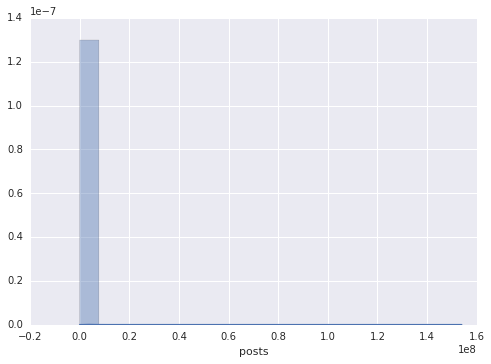

In [12]:
sns.distplot(g['posts_num'],bins=20, axlabel="posts")

We have 222,989 subreddits in the dataset. From the above histogram, we can see that the overwhelming majority of subreddits have very few posts. Let's look at the histogram of subreddits with at least a million posts. 

189 subreddits with at least a million posts


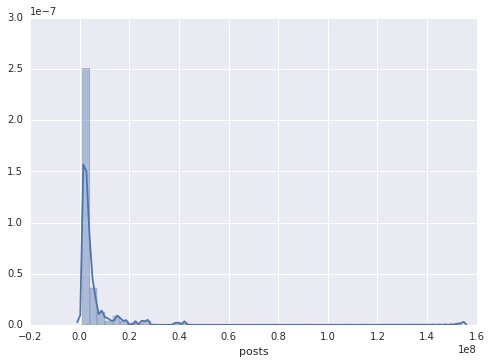

In [13]:
g_mil = g[g['posts_num'] >= 1000000]
print "%s subreddits with at least a million posts" % len(g_mil)
sns.distplot(g_mil['posts_num'], axlabel="posts")

We discover that only 189 subreddits, 0.085% of all the subreddits, contain more than a million posts. Let's calculate how many posts these subreddits contain in total.

In [14]:
print "The most popular subreddits contain %s posts" % g_mil['posts_num'].sum()

The most popular subreddits contain 920255973 posts


The most popular subreddits contain over 920 million posts. In other words, 0.085% of the subreddits contain 64.8% of the posts.
This result reminds me of the fact that over 57% of the world's population live in the ten most populous [countries](https://en.wikipedia.org/wiki/World_population).

Let's map the users’ activity in each subbreddit. Namely, we will find how many distinct user names there are in each subreddit, and what subreddits have the most unique users.

In [15]:
g = sf.groupby('subreddit', {'distinct_authors_number':agg.COUNT_DISTINCT('author')})
g = g.sort('distinct_authors_number', ascending=False)
g.print_rows(100)

+----------------------+-------------------------+
|      subreddit       | distinct_authors_number |
+----------------------+-------------------------+
|      AskReddit       |         4043528         |
|        funny         |         2597295         |
|         pics         |         2478957         |
|         IAmA         |         1810075         |
|         WTF          |         1732201         |
|        gaming        |         1640119         |
|        videos        |         1504645         |
|    AdviceAnimals     |         1499336         |
|    todayilearned     |         1410260         |
|         aww          |         1146100         |
|      worldnews       |         1040681         |
|        Music         |          978804         |
|        movies        |          935939         |
|       atheism        |          818344         |
|         gifs         |          806740         |
|       politics       |          794996         |
|      reddit.com      |       

By calculating the elapsed time between users' first post and last post, we can also estimate how much time users have been active in each subreddit.

In [18]:
#Important: running the following code block may take considerable time
sf['created_utc'] = sf['created_utc'].astype(int)
subreddit_users = sf.groupby(['subreddit', 'author'], {'start_date':agg.MIN('created_utc'), 'end_date': agg.MAX('created_utc'), 'posts_num':agg.COUNT()} )
subreddit_users['activity_time'] = subreddit_users.apply(lambda d: d['end_date'] - d['start_date'])
subreddit_users

author,subreddit,start_date,end_date,posts_num,activity_time
hellmouth,BuyItForLife,1375246927,1391550508,2,16303581
Bmoore4u,videos,1421096848,1421096848,1,0
Hooptie77,gaming,1384927397,1389434525,2,4507128
Rellik_Ladicius,movies,1418183444,1418183444,1,0
skateBW775,snowboarding,1425586361,1425586361,1,0
hmatmotu,gaming,1351271994,1428582555,10,77310561
JayDutch,Borderporn,1431579444,1431579444,1,0
Smileyselfie,TwoXChromosomes,1403492575,1412132885,5,8640310
CasperGhostGirl,TheGirlSurvivalGuide,1395698990,1395718695,2,19705
Dissociopath,Anger,1372363805,1372363805,1,0


Let's calculate the average time users have been active in each subreddit. To understand the activity time distribution across the subreddits, let's plot a histogram of average activity time.

In [19]:
g = subreddit_users.groupby('subreddit', {'avg_active_time_in_seconds': agg.AVG('activity_time')})

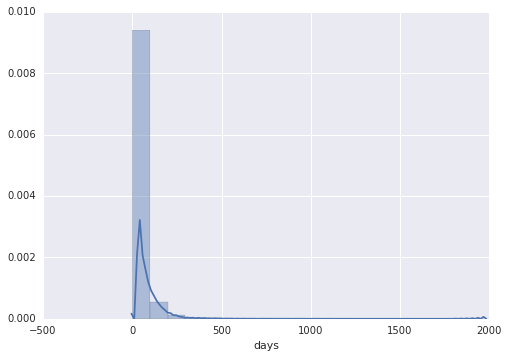

In [20]:
g['avg_active_time_in_days'] = g['avg_active_time_in_seconds'].apply(lambda sec: sec/(60.0*60.0*24))
sns.distplot(g['avg_active_time_in_days'], axlabel="days", bins=20 )

In [22]:
g['avg_active_time_in_days'].sketch_summary()


+--------------------+---------------+----------+
|        item        |     value     | is exact |
+--------------------+---------------+----------+
|       Length       |     222989    |   Yes    |
|        Min         |      0.0      |   Yes    |
|        Max         | 1978.59590278 |   Yes    |
|        Mean        | 23.5519125094 |   Yes    |
|        Sum         | 5251817.41856 |   Yes    |
|      Variance      | 3234.08400288 |   Yes    |
| Standard Deviation | 56.8690074019 |   Yes    |
|  # Missing Values  |       0       |   Yes    |
|  # unique values   |     132365    |    No    |
+--------------------+---------------+----------+

Most frequent items:
+-------+-------+-------------------+-------------------+-------------------+-------------------+
| value |  0.0  | 1.15740740741e-05 | 2.31481481481e-05 | 8.10185185185e-05 | 0.000115740740741 |
+-------+-------+-------------------+-------------------+-------------------+-------------------+
| count | 80847 |        220     

We can see from the above results that most the subreddits' users are active for a very limited time, with an average of less than a month and a median of less than a day.

## 3. User Arrival Curves

In our [study](http://homes.cs.washington.edu/~fire/pdf/reddatait.pdf), we focused on analyzing the various patterns in which users join each subreddit (also referred to as User Arrival Curves). In this section, we present the code that was used to create these curves. To create the user arrival curve of each subreddit, we first created a [TimeSeries object](https://turi.com/products/create/docs/generated/graphlab.TimeSeries.html) with the subreddit information. Throughout this section, we will use the [rickandmorty](https://www.reddit.com/r/rickandmorty/) subreddit as an example.

In [24]:
from datetime import datetime, timedelta

rm_sf = sf[sf['subreddit'] =='rickandmorty']
rm_sf['datetime'] = rm_sf['created_utc'].apply(lambda utc:datetime.utcfromtimestamp(utc))
subreddit_ts = gl.TimeSeries(rm_sf, index='datetime')
subreddit_ts

datetime,author,author_flair_css_class,author_flair_text,body,controversiality
2013-06-02 23:37:16,fraac,null,null,I volunteer. I'lltechnically be stealing ...,0
2013-06-03 07:02:53,owlcar,null,null,i'll do it,0
2013-06-03 15:27:53,mracidglee,null,null,I-I'll do it Mharti. Butfirst you have to lic ...,0
2013-06-05 20:44:55,LuiguSefirosu,slipperystair,,I could help...,0
2013-06-08 04:07:34,lvl5LazorLotus,me,,i'll help! I love the Docand Mharti stuff. ...,0
2013-06-08 10:40:56,justinroiland,none,R&amp;M Co-Creator,This guy expects to waltzin here and take the ...,0
2013-06-08 11:13:28,lvl5LazorLotus,me,,"You're goddamn right I'mtaking over, and I ain't ...",0
2013-06-08 22:52:22,LuiguSefirosu,slipperystair,,Trial by battle!,0
2013-06-09 02:10:40,justinroiland,none,R&amp;M Co-Creator,BATTLE!,0
2013-06-15 04:33:26,ladybuoy,null,null,I don't know. It seems tobe lacking the charm of ...,0


We will use the following function to create the subreddit user arrival curve from the TimeSeries object.

In [26]:
import math
def get_subreddit_users_arrival_curve(subreddit_ts, weeks_number=4):
    """
    Calculates the percent of authors that joined after X weeks from all authors that joined the subreddit
    between the date of the first comment and the date of the last comment
    :param subreddit_ts: TimeSeries with the subreddit posts information
    :param weeks_number: the number of weeks to set the time-interval between each two calculations
    :return: dict in which all the keys are the number of weeks since the first comment was posted and the
        corresponding percentage of authors that joined the subreddit up until this week
    :rtype: dict
    """
    dt = subreddit_ts.min_time
    end_dt = subreddit_ts.max_time
    authors = set()
    d = {0: 0}
    td = timedelta(days=7 * weeks_number)
    count = 1
    total_authors_num = float(len(subreddit_ts['author'].unique()))    
    while dt + td <= end_dt:
        ts = subreddit_ts.slice(dt, dt + td)
        authors |= set(ts['author'])
        print "Calculating the user arrival curve between %s and %s" % (dt, dt + td) 
        dt += td
        d[count * weeks_number] = len(authors) / total_authors_num
        count += 1
    ts = subreddit_ts.slice(dt, subreddit_ts.max_time)
    authors |= set(ts['author'])
    subreddit_age = subreddit_ts.max_time - subreddit_ts.min_time
    d[math.ceil(     subreddit_age.days/ 7.0)] = len(
        authors) / total_authors_num  # round the number of weeks up mainly for drawing the graph
    return d
d = get_subreddit_users_arrival_curve(subreddit_ts)

Calculating the user arrival curve between 2013-06-02 23:37:16 and 2013-06-30 23:37:16
Calculating the user arrival curve between 2013-06-30 23:37:16 and 2013-07-28 23:37:16
Calculating the user arrival curve between 2013-07-28 23:37:16 and 2013-08-25 23:37:16
Calculating the user arrival curve between 2013-08-25 23:37:16 and 2013-09-22 23:37:16
Calculating the user arrival curve between 2013-09-22 23:37:16 and 2013-10-20 23:37:16
Calculating the user arrival curve between 2013-10-20 23:37:16 and 2013-11-17 23:37:16
Calculating the user arrival curve between 2013-11-17 23:37:16 and 2013-12-15 23:37:16
Calculating the user arrival curve between 2013-12-15 23:37:16 and 2014-01-12 23:37:16
Calculating the user arrival curve between 2014-01-12 23:37:16 and 2014-02-09 23:37:16
Calculating the user arrival curve between 2014-02-09 23:37:16 and 2014-03-09 23:37:16
Calculating the user arrival curve between 2014-03-09 23:37:16 and 2014-04-06 23:37:16
Calculating the user arrival curve between 

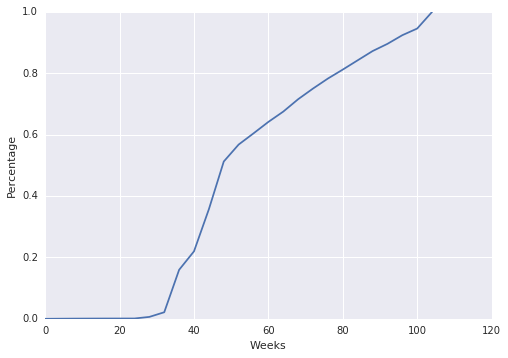

In [27]:
plt.plot(d.keys(), d.values())
plt.xlabel('Weeks')
plt.ylabel('Percentage')

## 4. Creating the Subreddit Social Network

In our study, we constructed the subreddit social networks by creating links between users that replied to other users’ posts. In this section, we will present the code which was used to create the subreddits' underlying social networks. As an example, we will use the [Datasets subreddit's](https://www.reddit.com/r/datasets) social network.

In [28]:
def create_subreddit_social_network(sf):
    """
    Creates an SGraph object of the subreddit
    :param sf: a Subreddit SFrame object
    :return: SGraph object
    :rtype: gl.SGraph
    """
    authors_stats_sframe = sf.groupby("author", {"posts_num": agg.COUNT(), "first_comment_date": agg.MIN("created_utc"),
                                         "last_comment_date": agg.MAX("created_utc")})

    sf = sf[sf['author', 'name', 'parent_id'].apply(
        lambda d: d['name'].startswith('t1_') and d['parent_id'].startswith('t1_'))]
    sf = sf['author', "created_utc", "name", "parent_id"]
    sf = sf.join(sf, on={"parent_id": "name"})
    sf.rename({'author': 'src', 'author.1': 'dst'})
    sn_sf = sf.groupby(['src', 'dst'],
                       {"strength": gl.aggregate.COUNT(), "first_comment_date": gl.aggregate.MIN("created_utc"),
                        "last_comment_date": gl.aggregate.MAX("created_utc")})

    g = gl.SGraph(vertices=authors_stats_sframe, edges=sn_sf, vid_field='author',
                  src_field='src', dst_field='dst')
    return g
datasets_sf = sf[sf['subreddit'] =='datasets']
g = create_subreddit_social_network(datasets_sf)


We created an [SGraph object](https://turi.com/products/create/docs/generated/graphlab.SGraph.html) from the SFrame. Let's visualize the constructed social network.

In [29]:
g.summary()

{'num_edges': 871, 'num_vertices': 2127}

We can use GraphLab's [analytics toolkit](https://turi.com/products/create/docs/graphlab.toolkits.graph_analytics.html) to calculate various topological properties, such as the degree distribution and the graph's number of triangles. I hope to elaborate on this in a future tutorial.
For now, let's use [Networkx package](https://networkx.github.io) to draw this subreddit's social network.

In [30]:
import networkx as nx
def sgraph2nxgraph(sgraph):
    """ Converts a directed sgraph object into networkx object
    :param sgraph: GraphLab SGraph object
    :return: Networkx Directed Graph object
    """
    nx_g = nx.DiGraph()
    vertices = list(sgraph.get_vertices()['__id'])
    edges = [(e['__src_id'], e['__dst_id']) for e in sgraph.get_edges()]
    nx_g.add_nodes_from(vertices)
    nx_g.add_edges_from(edges)
    return nx_g
nx_g = sgraph2nxgraph(g)

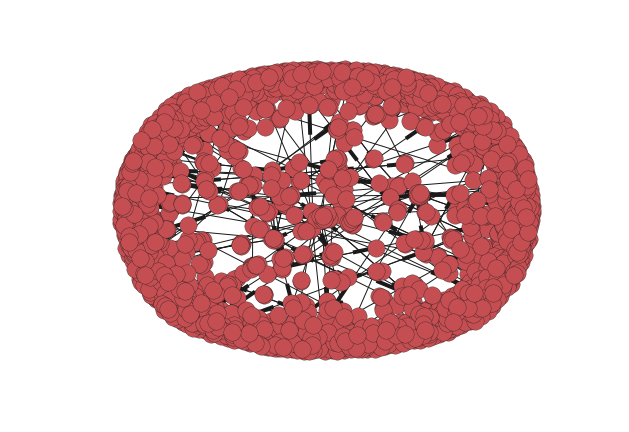

In [32]:
nx.draw(nx_g)


## 5. Where to Go from Here


The social network dataset created as a result of our study opens the door for new and exciting research opportunities. This dataset can help not only to better understand the social structure of the Reddit community in particular, but also to understand how social networks and online communities evolve over time. Moreover, this corpus can be used as a ground-truth dataset for many studies in field of social networks. Some examples of what can be done with this corpus are:
* Understanding topological factors that may help a post to go viral.
* Helping to better understand diffusion models and also assisting to validate diffusion models using real-world data.
* Using this dataset as an excellent ground-truth dataset for evaluating entity-matching algorithms, based on our observation that many redditors are members in several subreddits.
* Helping understand the connection between content and social networks; for instance, this dataset can provide insight on what type of content makes users more likely to interact with each other.


I would love to hear other ideas on what possible work can be done with our [provided datasets](http://homes.cs.washington.edu/~fire/reddatait/data.html).

## 6. Further Reading

Further reading material:
* [I have every publicly available Reddit comment for research. ~ 1.7 billion comments @ 250 GB compressed. Any interest in this?](https://www.reddit.com/r/datasets/comments/3bxlg7/i_have_every_publicly_available_reddit_comment)
* [Analyzing Complex Network User Arrival Patterns and Their Effect on Network Topologies ](http://homes.cs.washington.edu/~fire/pdf/reddatait.pdf)
* [Navigating the massive world of Reddit: using backbone networks to map user interests in social media](https://peerj.com/articles/cs-4/)
* [Don't feed the troll: Shutting down debate about community expectations on Reddit.com](http://firstmonday.org/ojs/index.php/fm/article/viewArticle/3498/3029)
* [GraphLab Create User Guide](https://turi.com/learn/userguide/)
